<a href="https://colab.research.google.com/github/BilyHakim/Machine-Learning/blob/main/Model_Nudity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepared Dataset

In [ ]:
pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1ZHHrIfMY-VY3gZifV3ggV74U5-_0ODIW

Downloading...
From: https://drive.google.com/uc?id=1ZHHrIfMY-VY3gZifV3ggV74U5-_0ODIW
To: /content/dataset.zip
100% 3.63G/3.63G [00:52<00:00, 69.5MB/s]


In [ ]:
!unzip /content/dataset.zip -d /content

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu002-olQit3y.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu003-TxJ0fby.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu004-YzdVpOT.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz0tu005-BD02XTH.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789001-F9McLXe.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789002-6mDNuDv.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789003-9Px5MWq.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789004-7PunV9e.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789005-VPjPJRF.jpg.jpeg  
  inflating: /content/dataset/training/safe/reddit_sub_rateme_avz789006-j1CYnbr.jpg.jpeg  
  inflating: /content/dataset/t

In [ ]:
# Mengatur path ke dataset Anda
train_dir = '/content/dataset/training'
valid_dir = '/content/dataset/validation'
test_dir = '/content/dataset/testing'

## InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.utils import get_file

In [ ]:
# Set the weights file URL
weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# Set the local path to save the weights file
local_weights_file = get_file('inception_v3_weights.h5', weights_url, cache_dir='/tmp/', cache_subdir='models')

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), 
                               include_top=False, 
                               weights=None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( valid_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 17500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
# Menggunakan Metode early stopping
from tensorflow.keras.callbacks import EarlyStopping

# Set the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Train the model.
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/20
100/100 - 112s - loss: 0.4387 - accuracy: 0.8255 - val_loss: 0.4046 - val_accuracy: 0.8410 - 112s/epoch - 1s/step
Epoch 2/20
100/100 - 102s - loss: 0.2703 - accuracy: 0.8905 - val_loss: 0.4581 - val_accuracy: 0.8380 - 102s/epoch - 1s/step
Epoch 3/20
100/100 - 100s - loss: 0.3100 - accuracy: 0.8815 - val_loss: 0.5386 - val_accuracy: 0.8080 - 100s/epoch - 998ms/step
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (94247712 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


100/100 - 87s - loss: 0.2599 - accuracy: 0.8990 - val_loss: 0.5111 - val_accuracy: 0.8160 - 87s/epoch - 869ms/step


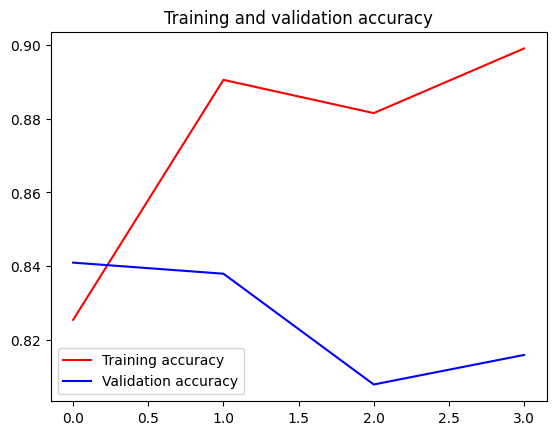

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Evaluasi model pada data pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 3750 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

118/118 [==============================] - 34s 279ms/step - loss: 0.7239 - accuracy: 0.7584
Test loss: 0.7239370346069336
Test accuracy: 0.758400022983551


### Prediksi Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

In [ ]:
# Function to preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

In [ ]:
# Function to make predictions
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)

    # Threshold for classifying as NSFW
    nsfw_threshold = 0.5

    if predictions[0][0] <= nsfw_threshold:
        print("The image contains NSFW content.")
    else:
        print("The image is safe.")

In [ ]:
import os

# Path folder gambar
folder_path = "/content/dataset-testing"

# Mendapatkan daftar file dalam folder
file_list = os.listdir(folder_path)

# Loop untuk memprediksi setiap gambar
for file_name in file_list:
    # Membuat path lengkap ke file gambar
    image_file = os.path.join(folder_path, file_name)
    
    # Melakukan prediksi gambar
    prediction = predict_image(image_file)
    
    # Menampilkan hasil prediksi
    print(f"Prediction for {file_name}: {prediction}")

1/1 [==============================] - 2s 2s/step
The image contains NSFW content.
Prediction for 2.jpeg: None
1/1 [==============================] - 0s 36ms/step
The image is safe.
Prediction for 4.jpg: None
1/1 [==============================] - 0s 37ms/step
The image is safe.
Prediction for 5.jpg: None
1/1 [==============================] - 0s 36ms/step
The image contains NSFW content.
Prediction for 1.jpeg: None
1/1 [==============================] - 0s 38ms/step
The image contains NSFW content.
Prediction for 3.jpeg: None
